In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch.utils.data import DataLoader

from dataset import (
    WrappedDataLoader,
    get_image_paths_df,
    split_dataset,
)
from network import Generator, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_paths_df = get_image_paths_df(Path("data_col_public/"), 500)

train_dataset, val_dataset, _ = split_dataset(img_paths_df, 0.10, 0.1)

train_dataloader = WrappedDataLoader(
    DataLoader(train_dataset, shuffle=True, batch_size=16, num_workers=10),
    device,
)
val_dataloader = WrappedDataLoader(
    DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4),
    device,
)

G = Generator().to(device)
D = Discriminator(6).to(device)

In [8]:
targets.shape

torch.Size([16, 3, 512, 384])

In [9]:
inputs, targets = next(iter(val_dataloader))
print(inputs.shape)
generated_images = G(inputs)
print(torch.concat((inputs, targets), dim=1).shape)
D(torch.concat((inputs,targets), dim=1))

torch.Size([16, 3, 512, 384])
torch.Size([16, 6, 512, 384])


tensor([[[[ 1.3373e+00,  1.2654e+00,  8.9868e-01,  ...,  9.7200e-01,
            1.0913e+00,  9.9730e-01],
          [ 1.4137e+00,  3.2800e-01,  1.1379e-01,  ...,  6.1317e-01,
            5.8361e-01,  7.0758e-01],
          [ 1.3785e+00,  7.7645e-01,  5.1825e-01,  ...,  1.1375e+00,
            8.6097e-01,  1.0164e+00],
          ...,
          [-4.4988e-01,  5.7899e-01,  4.5747e-02,  ..., -2.1207e-01,
            3.6343e-01,  2.5273e-01],
          [-6.1474e-01,  7.7070e-01,  1.4679e-01,  ...,  1.3166e-01,
            4.2186e-01,  5.8929e-01],
          [ 3.8051e-01,  1.0675e+00,  4.9737e-01,  ...,  6.3710e-01,
            9.7211e-01,  9.6690e-01]]],


        [[[ 1.8721e+00,  1.7199e+00,  1.5696e+00,  ...,  1.5533e-01,
            5.5062e-01,  6.5784e-01],
          [ 2.0954e+00,  7.5540e-01,  7.8003e-01,  ..., -5.5798e-01,
            1.5878e-01, -1.2678e-01],
          [ 2.1433e+00,  9.9228e-01,  1.0030e+00,  ..., -8.2356e-02,
            5.8697e-01,  9.7300e-02],
          ...,
   

In [3]:
val_dataset[0][1].shape

torch.Size([3, 512, 384])

In [4]:
@torch.no_grad
def visualize_batch_grid(
    model: Generator,
    inputs: Tensor,
    targets: Tensor,
    epoch: int,
    save=True,
    save_path=Path("gen_images/batch"),
):
    model.eval()
    generated_imgs = model(inputs).cpu().permute(0, 2, 3, 1).numpy()
    model.train()
    grayscale = inputs.cpu().permute(0, 2, 3, 1).numpy()
    ground_truth = targets.cpu().permute(0, 2, 3, 1).numpy()

    if grayscale.min() < 0 or grayscale.max() > 1:
        grayscale = (grayscale - grayscale.min()) / (grayscale.max() - grayscale.min())

    if ground_truth.min() < 0 or ground_truth.max() > 1:
        ground_truth = (ground_truth - ground_truth.min()) / (
            ground_truth.max() - ground_truth.min()
        )

    if generated_imgs.min() < 0 or generated_imgs.max() > 1:
        generated_imgs = (generated_imgs - generated_imgs.min()) / (
            generated_imgs.max() - generated_imgs.min()
        )

    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(grayscale[i], cmap="gray")
        ax.axis("off")
        if i == 2:
            ax.set_title("Grayscale", fontsize=12)

        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(ground_truth[i])
        ax.axis("off")
        if i == 2:
            ax.set_title("Ground Truth", fontsize=12)

        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(generated_imgs[i])
        ax.axis("off")
        if i == 2:
            ax.set_title("Generated", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    if save:
        save_path.mkdir(exist_ok=True)
        path = save_path / f"generated_images_{epoch}.png"
        print(f"Sample colorized image saved to {path}")
        plt.savefig(path)
        plt.close()
    else:
        plt.show()


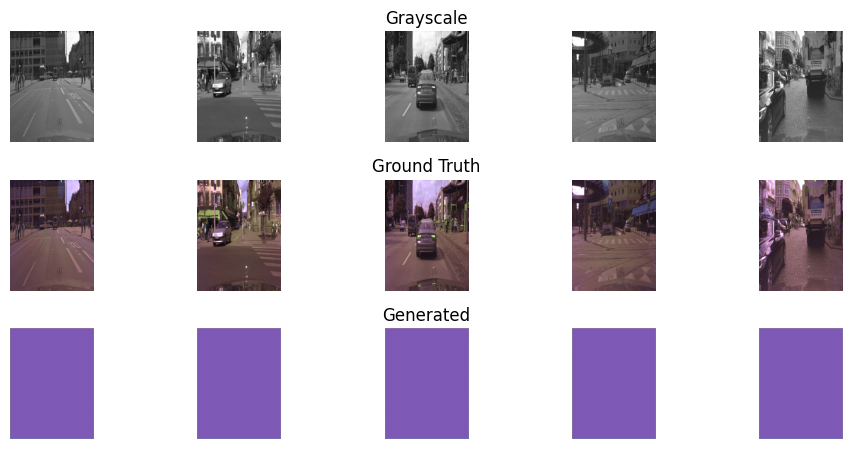

In [5]:
visualize_batch_grid(G, inputs, targets, 1, False)

In [7]:
generated_images.min()

tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)

In [8]:
@torch.no_grad
def generate_image(
    model: Generator,
    input: Tensor,
    target: Tensor,
    epoch: int,
    plot_subtitle: str = "",
    save: bool = True,
    save_path=Path("gen_images/single"),
):
    # input has a shape C x H x W
    # target has a shape C x H x W
    model.eval()
    predicted = model(input.unsqueeze(0))  # add a batch dimension
    model.train()
    target_np = target.permute(1, 2, 0).cpu().detach().numpy()
    predicted_np = predicted.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    input_np = input.permute(1, 2, 0).cpu().detach().numpy()

    if input_np.min() < 0 or input_np.max() > 1:
        input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())

    if target_np.min() < 0 or target_np.max() > 1:
        target_np = (target_np - target_np.min()) / (target_np.max() - target_np.min())

    if predicted_np.min() < 0 or predicted_np.max() > 1:
        predicted_np = (predicted_np - predicted_np.min()) / (
            predicted_np.max() - predicted_np.min()
        )

    plt.figure(figsize=(10, 5))

    display_list = [input_np, target_np, predicted_np]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)

        plt.title(title[i])
        if title[i] == "Input Image":
            plt.imshow(display_list[i], cmap="gray")
        else:
            plt.imshow(display_list[i])
        plt.axis("off")
    plt.suptitle(plot_subtitle)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        save_path.mkdir(exist_ok=True)
        path = save_path / f"generated_image_{epoch}.png"
        print(f"Sample colorized image saved to {path}")
        plt.savefig(path)
        plt.close()
    else:
        plt.show()

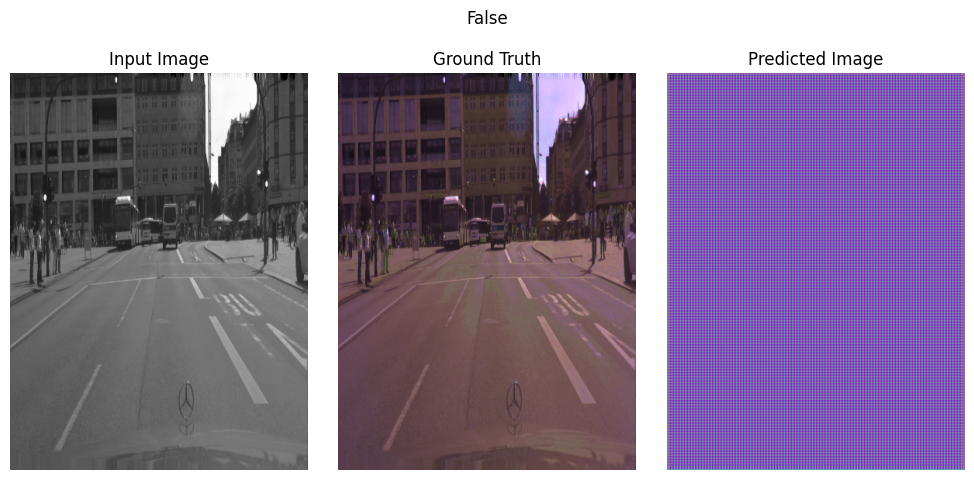

In [9]:
generate_image(G, inputs[0], targets[0], 1, False, save=False)

In [12]:
inputs[0][2]

tensor([[-0.9990, -0.9987, -0.9985,  ..., -0.9987, -0.9991, -0.9985],
        [-0.9997, -0.9991, -0.9985,  ..., -0.9987, -0.9990, -0.9985],
        [-0.9995, -0.9989, -0.9984,  ..., -0.9987, -0.9990, -0.9985],
        ...,
        [-0.9974, -0.9974, -0.9974,  ..., -0.9969, -0.9972, -0.9975],
        [-0.9974, -0.9974, -0.9974,  ..., -0.9969, -0.9969, -0.9975],
        [-0.9974, -0.9974, -0.9974,  ..., -0.9969, -0.9969, -0.9969]],
       device='cuda:0')